In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import add_dummy_feature
from sklearn.linear_model import LinearRegression

In [8]:
np.random.seed(42)
m = 100 # number of instances
X = 2 * np.random.rand(m, 1) #column vector
y = 4 + 3 * X + np.random.randn(m, 1) #column vector

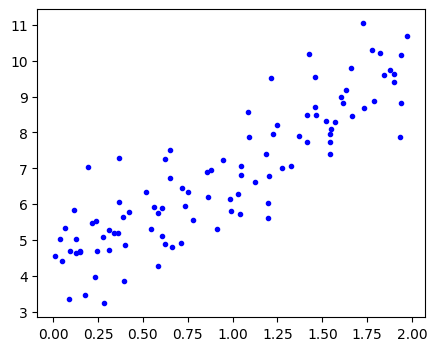

In [15]:
plt.figure(figsize=(5,4))
plt.plot(X, y, "b.")

In [30]:
# calculating normal equation
X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
print(theta_best, "best parameters from the values")
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
print(y_predict, "Predictions")

[[4.21509616]
 [2.77011339]] best parameters from the values
[[4.21509616]
 [9.75532293]] Predictions


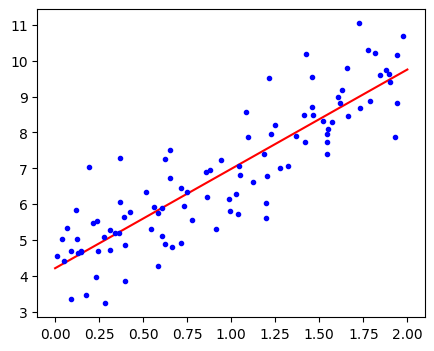

In [27]:
plt.figure(figsize=(5, 4))

plt.plot(X_new, y_predict, 'r-', label="Predictions")
plt.plot(X, y, 'b.')
plt.show()

In [36]:
# coding gradient descent
eta = .1 # learning rate
n_epochs = 1000
m = len(X_b) #number of instances

np.random.seed(42)
theta = np.random.randn(2,1) #randomly initialized model parameters

for _ in range(n_epochs):
    gradients = 2/m* X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta #last gradient theta values

array([[4.21509616],
       [2.77011339]])